In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

In [2]:
def show(log, title):
    X = [l[0] for l in log]
    Y = [l[1] for l in log]
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(X, Y)
    best = log[-1][1]
    if isinstance(best, list):
        best = best[-1]
    plt.title(title + ' %is, best: %i' % (int(log[-1][-1]), best))
    plt.subplot(122)
    imshow(log[-1][2])

### Maciej Pawlikowski
# Mona Lisa

Celem projektu było zastosowanie kilku algorytmów ewolucyjnych do odtwarzania obrazu za pomocą wielokątów. Wykorzystane algorytmy szacowania rozkładu pochodzą z wykładu, mutacja w algorytmie hill climbing jest inspirowana blogiem Rogera Alsinga:

[1] https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/

Językiem całego projektu jest Python 2.7.

## Zagadnienie

Dany jest obrazek w przestrzeni RGB. Chcemy go możliwie dokładnie odwzorować korzystając z przezroczystych wielokątów. Maksymalna dozwolona liczba $K$ figur i $W$ wierzchołków w figurze jest ustalana przy starcie algorytmu.

Chromosomem jest ciąg $K$ figur. Każda figura składa się z $2W$ liczb oznaczających współrzędne wierzchołków i z czterech liczb określających kolor figury w RGBA. Całkowita długość chromosomu to zatem $K(2W+4)$, co na przykład dla 50 trójkątów daje 500. W różnych algorytmach jest różne kodowanie cech, ale zmiana jest tylko w skalowaniu. Czasami używałem dla każdego paramtetru przedziału $[0,1]$, a czasami odpowiedniego przedziału liczb całkowitych, np. $[0,255]$ dla każdego z kolorów.

Obliczanie funkcji celu składa się z dwóch etapów. Najpierw trzeba na podstawie chromosomu (wpółrzędnych i kolorów wielokątów) narysować obrazek. W tym celu korzystam z biblioteki Pillow. Wielokąty zawsze są rysowane w tej samej kolejności, według występowania w chromosomie (kolejność rysowania ma oczywiście znaczenie ze względu na pokrywanie się figur). Dla tak powstałego obrazka liczę średnią kwadratów odległości po pikselach od obrazka bazowego. Odległość między dwoma pikselami w RGB to odległość euklidesowa w $R^3$.

Implementacja niektórych algorytmów korzysta z `numpy`. W przypadku hill climbing okazało się, że się to nie opłaca ze względu na malutką populację i bardzo wolną mutację, więc tam są normalne pythonowe tablice i moduł `random`.

Obrazek bazowy znajdujący się poniżej ma wymiary 100 x 100. Przeprowadziłem dwa testy:

- T1: 50 trójkątów
- T2: 50 wielokątów o maksymalnej liczbie boków równej 10

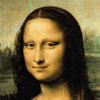

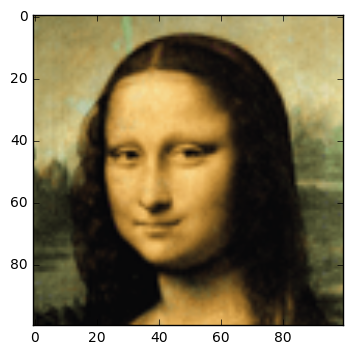

In [3]:
img = Image.open('../img/monalisa.png')
imshow(img)
img

## Pierwsze podejście

Pierwszym pomysłem było wykorzystanie poznanych na wykładzie algorytmów optymalizacji ciągłej: SHCLVND i strategii ewolucyjnych.

### SHCLVND

Próbujemy oszacować parametry rozkładu normalnego dla każdej wartości występującej w chromosomie. Zaczynamy losując średnie $\mu_i$ z rozkładów jednostajnych o odpowiednich zasięgach i ustawiając początkowe odchylenia standardowe $\sigma_i$. W każdej iteracji losujemy populację z rozkładem N$(\mu, \sigma^2)$, po czym aktualizujemy parametry w następujący sposób:

$$\mu^{t+1} = \mu^t + \alpha (b - \mu^t)$$

$$\sigma^{t+1} = \beta \sigma^t,$$

gdzie $\alpha$ i $\beta$ są parametrami algorytmu, a $b$ jest średnią ustalonej liczby najlepszych osobników w iteracji $t$.

### ES($\mu + \lambda$)

W strategiach ewolucyjnych każdemu parametrowi w chromosomie przypisany jest dodatkowo parametr mutacji. Wykorzystałem algorytm w wersji omawianej na wykładzie, z selekcją wykonywaną metodą ruletki, zastępowaniem $(\mu + \lambda)$, aktualizacją odchyleń standardowych

$$\sigma^{t+1}_i = \sigma^t_i exp(\epsilon^t_i + N(0, \tau_0^2))$$

$$\epsilon^t_i = N(0, \tau^2)$$

$$\tau = \frac{k}{\sqrt{2d}}$$    

$$\tau_0 = \frac{k}{\sqrt{2 \sqrt{d}}}$$

i mutacją

$$x^{t+1} = x^t + N(0, {\sigma^{t+1}}^2).$$

Wykorzystany operator krzyżowania to *uniform crossover* traktujący poszczególne figury całościowo. Dziecko dostaje losowo wybraną połowę figur od pierwszego rodzica, a resztę od drugiego.

### Rezultat

Wypróbowałem algorytmy na teście T1. Niestety, ani SHCLVND, ani ES zupełnie się nie sprawdziły, przynajmniej w testowanych, podstawowych wariantach. Poniżej najlepsze uzyskane rezultaty po kilku próbach dla obu algorytmów. Jednym problemem było wygasanie sigm, przez co od pewnego momentu (który następował zdecydowanie za wcześnie) zmiany praktycznie nie zachodziły. Drugim był bardzo długi (wgzlędem następnych metod) czas działania, który moim zdaniem w problemie rekonstrukcji obrazu ma spore znaczenie. Być może po dokładniejszym tuningu te metody dałyby lepsze wyniki, ale po obejrzeniu obrazków i czasów z [1] stwierdziłem, że nie tędy droga. Jak się później okazało, dużo prostszy obliczeniowo algorytm potrafi szybciej dać znacząco lepszy rezultat.

Wykresy i obrazki są poniżej, w sekcji **Wyniki**.

## Drugie podejście

Po nieudanym zastosowaniu SHCLVND i ES postanowiłem wypróbować algorytm hill climbing, na który natknąłem się szukając obrazka Mona Lisy wielkości 100 x 100 pikseli. 

### Hill Climbing

Bardzo prosty algorytm: w każdej iteracji mamy jednego osobnika-matkę i produkujemy pewną liczbę dzieci (być może równą 1). Każde dziecko powstaje przez drobną modyfikację matki. Do następnej iteracji wybieramy najlepsze dziecko, jeśli jest lepsze od matki, lub matkę, w przeciwnym przypadku.

Na uwagę zasługuje sposób modyfikacji matki. Jest on bardzo ostrożny. Wybieramy losowo (z rozkładem jednostajnym) jedną współrzędną chromosomu (dla 50 trójkątów jedną z 500 liczb opisujących osobnika) i modyfikujemy ją. W znalezionej przeze mnie wersji do modyfikacji wykorzystany był rozkład trójkątny. Nowa wartośc osobnika to liczba wylosowana z rozkładu trójkątnego o odpowiednim zakresie (np. $[0,255]$ w przypadku kolorów) i o środku w aktualnej wartości modyfikowanej cechy.

Działanie algorytmu rozpoczynamy od wylosowania osobnika początkowego. Składa się on z $K$ trójkątów wylosowanych jednostajnie. W przypadku problemu T2, gdzie mamy do czynienia z dziesięciokątami, losowanie jednostajne wierzchołków może skutkować samoprzecinającymi się w wielu miejscach figurami, których optymalizacja intuicyjnie wydaje się trudniejsza. Oprócz losowania jednostajnego wypróbowałem następujący sposób:

- wylosuj początkowe trójkąty
- do każdego trójkąta dodawaj punkty dopóki nie stanie się on dzisięciokątem. Punkty dodajemy zgodnie z metodą opisaną w algorytmie poniżej.

Takie generowanie osobnika początkowego sprawdziło się trochę lepiej.

Funkcja gęstości rozkładu trójkątnego z zakresu $[a,b]$ o środku w $c$ wygląda tak:

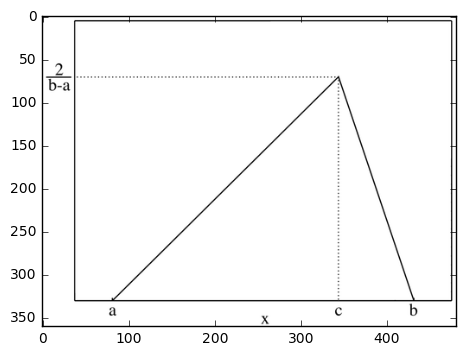

In [5]:
a = imshow(Image.open('triangular.png'))

Wykorzystując taki rozkład umożliwiamy duże modyfikacje parametrów, ale faworyzujemy małe, co jest pożądaną cechą w późnych etapach działania algorytmu. Dzięki temu nie musimy martwić się o wygasające sigmy (chociaż mamy mniejszą kontrolę nad tym co się dzieje i liczymy na to że dużo większa liczba kroków nam to zrekompensuje). Dla porównania sprawdziłem też rozkład jednostajny, który poradził sobie nieco gorzej.

Algorytmowi HC udało się osiągnąć zdecydowanie lepsze wyniki niż poprzednim metodom. Oczywiście nie występuje tu problem przedwczesnej zbieżności, więc mogłem z dobrym skutkiem zrobić dużo więcej iteracji. Rezultat podobny do SHCLVND pojawił się w HC po ułamku czasu działania SHCLVND, a przed osiągnięciem zadanego miliona iteracji wynik ciągle się poprawiał. Od tej pory nie zawracałem sobie głowy poprzednimi algorytmami, tylko sprawdzałem różne wersje HC.

### Dynamiczny Hill Climbing

*"Dynamiczny" nie ma żadnego związku z optymalizacją dynamiczną. Po prostu uznałem, że tutaj pasuje.*

Na obrazkach w [1] widać, że nie od razu wszystkie wielokąty są obecne. Kolejne są stopniowo dodawane podczas działania algorytmu. Przy mutacji osobnika losowana jest liczba, której wartość mówi, czy należy dodać wielokąt. Jeśli tak, to do obrazka dodawany jest losowy malutki trójkąt. Najpierw losowany jest jego środek, z rozkładem jednostajnym na całym obrazku, a następnie poszczególne wierzchołki, z rozkładem jednostajnych na przedziale środek $\pm$ kilka pikseli. Kolor nowej figury jest losowany z rozkładem jednostajnym na RGBA.

Analogicznie podczas mutacji każdego osobnika wielokąt może być usunięty. Za szansę usunięcia losowego wielokąta odpowiada osobny parametr.

W przypadku problemu T2 dochodzi dodawanie punktów do wielokątów o mniejszej niż 10 liczbie boków. Początkowo próbowałem dodawać losowe punkty, ale wtedy dostawaliśmy brzydkie, pokręcone wielokąty, które trudniej było dopasowywać. Pomysł zastosowany w [1] rozwiązuje ten problem: zamiast dodawać konkretny punkt, dodajemy "stawy", czyli dodatkowe miejsca, w których wielokąt może się wyginać. Kiedy mamy dodać punkt do istniejącego wielokątu, losujemy jeden z jego boków, po czym dodajemy punkt na środku tego boku, pomiędzy wierzchołkami tworzącymi bok. Prawdopodobieństwo dodania punktu do losowego wielokąta jest kontrolowane przez parametr algorytmu.

Podobnie jak w przypadku wielokątów, losowy punkt może również być usunięty.

Ostatnią zmianą względem podstawowego HC jest możliwość zmiany kolejności rysowania wielokątów. Czasami zdarza się, że wielokąt rysowany wcześnie dopasuje się do czegoś, to jest na pierwszym planie i przeszadza pozostałym figurom. Z małym prawdopodobieństwem losowy wielokąt w osobniku jest przestawiany na losową pozycję.

Poprawa w stosunku do podstawowej wersji Hill Climbing na problemie T1 jest niewielka (a nawet nie zawsze występuje), ale na T2 wersja dynamiczna sprawdza się dużo lepiej*.

****Poprawka: ten wniosek napisałem na podstawie wyjątkowo szczęśliwego przebiegu Dyn. HC, przy którym zapomniałem zapisać seed i nie mogę go już powtórzyć. W kolejnym uruchomieniu algorytm poradził sobie gorzej - wynik był na poziomie zwykłego HC, a na dużą poprawę należało poczekać dłużej. Wynik szczęśliwego uruchomienia jest na końcu tego sprawozdania.***

### Alsing Hill Climbing

Chciałem również sprawdzić jakie wyniki daje algorytm wykorzystany w [1]. W tym celu zapoznałem się z kodem źródłowym, który autor udostępnia i napisałem jego pythonową reimplementację. Różnica w stosunku do opisanego wcześniej dynamicznego HC jest subtelna. Autor robi trzy rzeczy:

- Wprowadza osobne prawdopodobieństwa mutacji dla każdego parametru chromosomu (mutacja wierzchołka, koloru, przezroczystości) i mutuje każdą z tych liczb niezależnie.


- Wprowadza trzy stopnie mutacje współrzędnych wierzchołków wielokątów:
    - pierwszy, najmocniejszy, stopień to losowanie współrzędnej od nowa z rozkładem jednostajnym
    - drugi, średni, to losowanie z przedziału `aktualna_pozycja` $\pm$ 20 pikseli
    - trzeci, najsłabszy, to losowanie z przedziału `aktualna_pozycja` $\pm$ 3 piksele
    
    
- Ustala sztuczne ograniczenie na łączną liczbę wierzchołków w całym osobniku i zmniejsza zakres modyfikacji alfy z RGBA z $[0,255]$ do $[30,60]$.

Nie wiem jakiego rozmiaru obrazka autor użył jako wzorca, ale na oko to jest jakieś 200 x 200. Z tego powodu przyjąłem średnią mutację $\pm$ 10% rozmiaru obrazka, a słabą $\pm$ 2%. Nie wiem jakich ograniczeń na łączną liczbę punktów Alsing użył do generowania przykładu na blogu, więc w mojej inplementacji go nie ma. Ograniczenie na alfę jest dla mnie niezrozumiałe i brzmi trochę jak zbyt mocne dostosowanie algorytmu do konkretnego obrazka. Testowana wersja go nie zawiera.

Przy dobieraniu parametrów do tej wersji oraz do Dyn. HC pomogłem sobie kodem Alsinga. Wartości nie są identyczne, ale stosunki między nimi są podobne. Ręczne dobranie optymalnych wartości parametrów byłoby dość trudne, więc są one rozdzielone na dwie grupy według pożądanej częstości występowania danej mutacji. Dodawanie wielokąta i przesuwanie figury w kolejce zdarzają się z szansą `0.002`, a pozostałe mutacje z szansą `0.001`.

## Wyniki

#### *Notka o wydajności*

Podstawowy HC działa tutaj dużo dłużej od wersji dynamicznej, bo jest (nieoptymalnie) napisany w `numpy`. Do przeprowadzenia mutacji używa skomplikowanego indeksowania, konwertuje osobniki z przedziału jednostkowego do właściwych wartości w każdej iteracji i losuje liczby korzystając z funkcji zawartych w `numpy`, które są trochę wolniejsze niż moduł `random`. Dla tak małej (1) liczby osobników nie opłaca się używać innych rzeczy niż podstawowe struktury i funkcje pythonowe. Nie zmieniałem implementacji, bo uznałem, że taka informacja też może być przydatna. W wersji optymalnej HC byłby oczywiście trochę szybszy od Dyn. HC.

Wersja Alsinga jest zaimplementowana, mam nadzieję, efektywnie. Jej czas działania wynika z liczby losowań przeprowadzanych w każdej iteracji.

## T1 (50 trójkątów)

### SHCLVND

Długi czas działania i przedwczesna zbieżność. Na tym etapie sigmy były już malutkie.

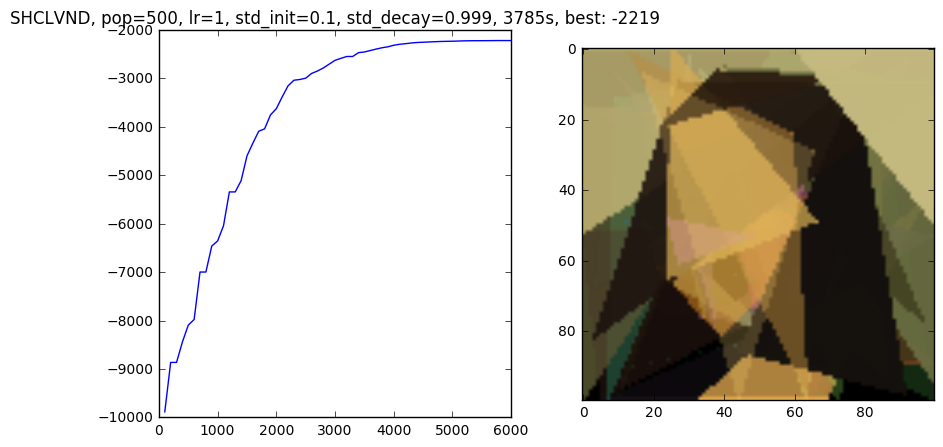

In [6]:
show(np.load('../res/shclvnd/mona_shclvnd_500_1.000_0.100_0.999_50_3_6000_12345.pkl'), 
     'SHCLVND, pop=500, lr=1, std_init=0.1, std_decay=0.999,')

***

Mniejsze tempo uczenia:

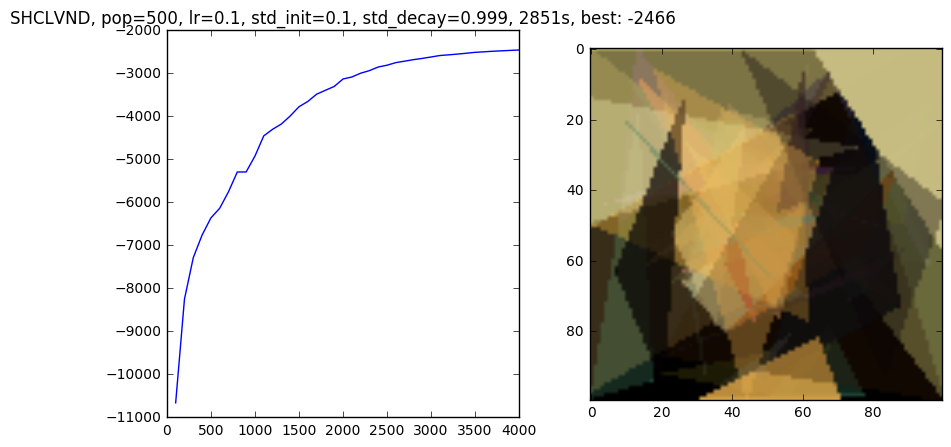

In [7]:
show(np.load('../res/shclvnd/mona_shclvnd_500_0.100_0.100_0.999_50_3_4000.pkl'), 
     'SHCLVND, pop=500, lr=0.1, std_init=0.1, std_decay=0.999,')

### ES

Tutaj można jeszcze czekać, bo algorytm nie osiągnął zbieżności, ale czas działania jest już nieakceptowalny.

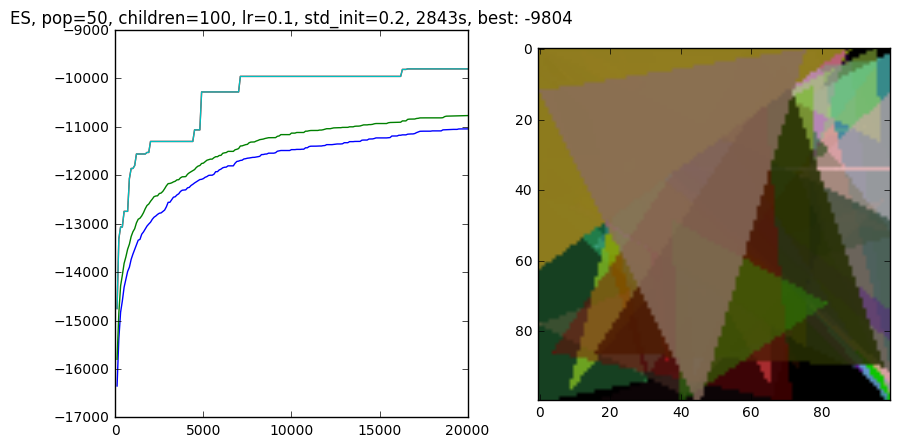

In [8]:
show(np.load('../res/es/mona_es_50_100_0.100_0.200_50_3_20000_12345.pkl'), 
     'ES, pop=50, children=100, lr=0.1, std_init=0.2,')

***

Przy większym tempie uczenia bardzo szybka zbieżność:

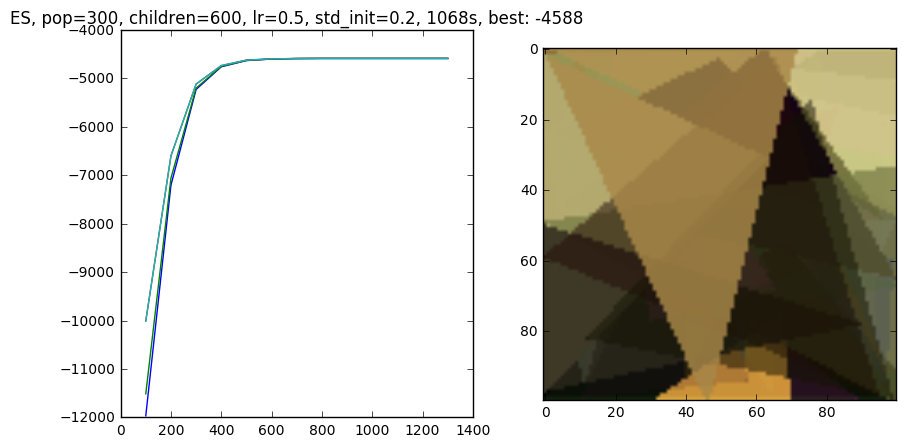

In [10]:
show(np.load('../res/es/mona_es_300_600_0.500_0.200_50_3_1308_12345.pkl'), 
     'ES, pop=300, children=600, lr=0.5, std_init=0.2,')

### Hill Climbing

Wersja z rozkładem trójkątnym.

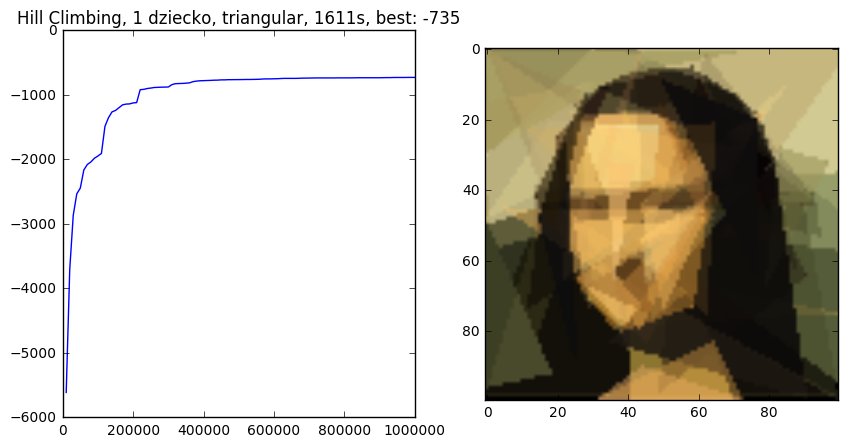

In [62]:
show(np.load('../res/hc/mona_hc_triangular_1_1_50_3_1000000.pkl'), 'Hill Climbing, 1 dziecko, triangular,')

***

Wersja z rozkładem jednostajnym.

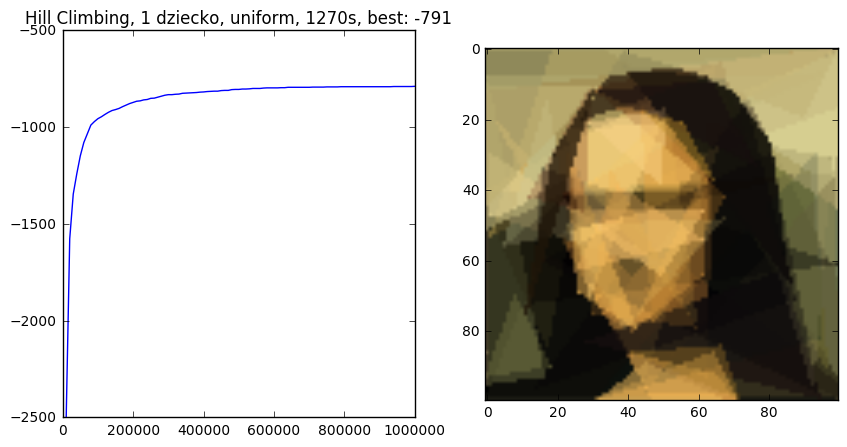

In [63]:
show(np.load('../res/hc/mona_hc_uniform_1_1_50_3_1000000.pkl'), 'Hill Climbing, 1 dziecko, uniform,')

### Dynamiczny Hill Climbing

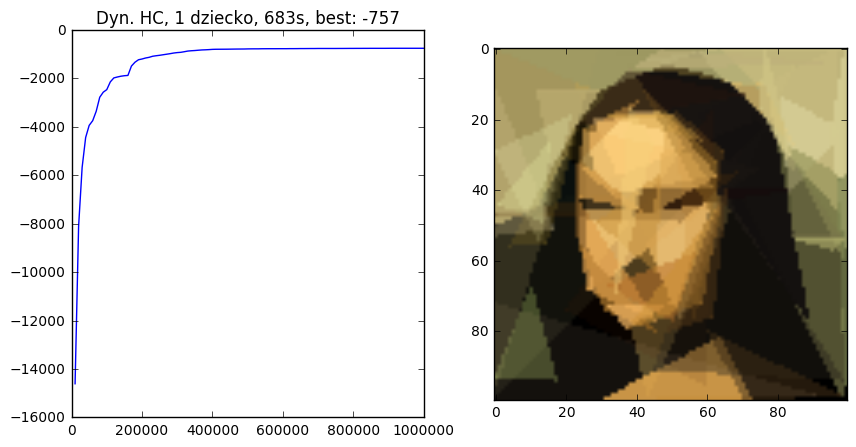

In [6]:
show(np.load('../res/hcdyn/mona_hcdyn_triangular_1_1_50_3_1000000.pkl'), 'Dyn. HC, 1 dziecko,')

***

Sprawdziłem też wersję, w której produkowane jest więcej dzieci na iterację. Nie wygląda na to, żeby cokolwiek to ulepszyło. Dostajemy szybszą zbieżność, co było do przewidzenia, ale ogólny wynik wcale nie jest lepszy. Patrząc po liczbie ocenianych osobników, a nie po liczbie iteracji, nawet zbieżność nie jest szybsza.

Wygląda na to, że natura problemu odtwarzania obrazu pozwala na bezpieczne wspinanie się po funkcji celu. Tzn. jeśli widzimy kierunek, który jest lepszy, to możemy bezpiecznie tam pójść. Ważniejsza od ogólnego kierunku zmian wydaje się sama liczba modyfikacji. Żeby dojść do dobrego rozwiązania trzeba wykonać mnóstwo małych kroczków, których kolejność i jakość ma być może mniejsze znaczenie.

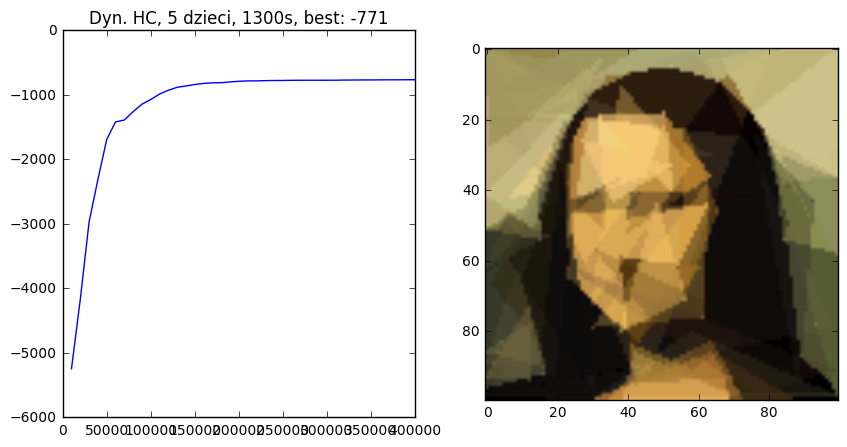

In [11]:
show(np.load('../res/hcdyn/mona_hcdyn_triangular_1_5_50_3_400000.pkl'), 'Dyn. HC, 5 dzieci,')

### Alsing Hill Climbing

Ta wersja dała najlepszy wynik po milionie iteracji i wygląda na to, że jeszcze coś się może zmienić po dołożeniu kolejnych.

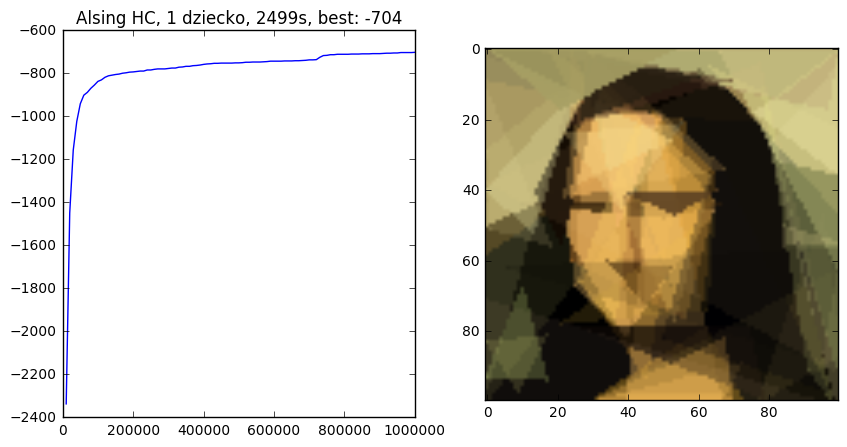

In [12]:
show(np.load('../res/hcals/mona_hcAls_1_1_50_3_1000000_12345.pkl'), 'Alsing HC, 1 dziecko,')

## T2 (50 dziesięciokątów)

### Hill Climbing

Wersja z jednostajnym inicjowaniem startowego osobnika.

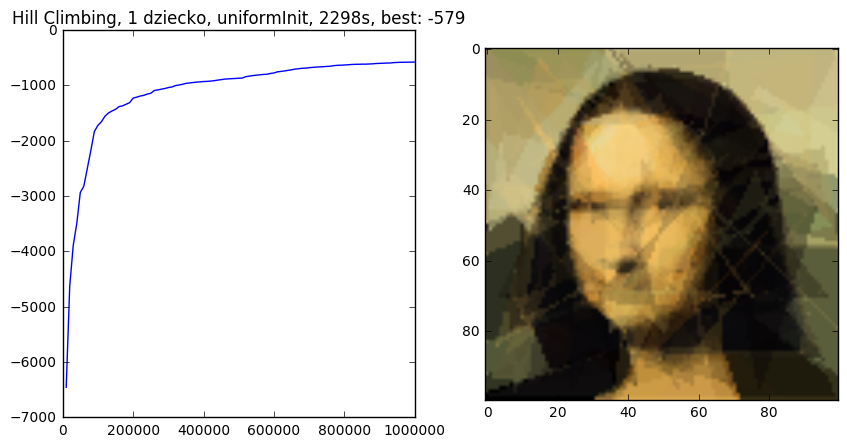

In [69]:
show(np.load('../res/hc/mona_uniformInit_hc_triangular_1_1_50_10_1000000.pkl'), 'Hill Climbing, 1 dziecko, uniformInit,')

***

Wersja z inicjowaniem za pomocą trójkątów ze stawami. Lepszy wynik po milionie iteracji (chociaż wersja jednostajna jeszcze by się pewnie poprawiła). Szybsza zbieżność.

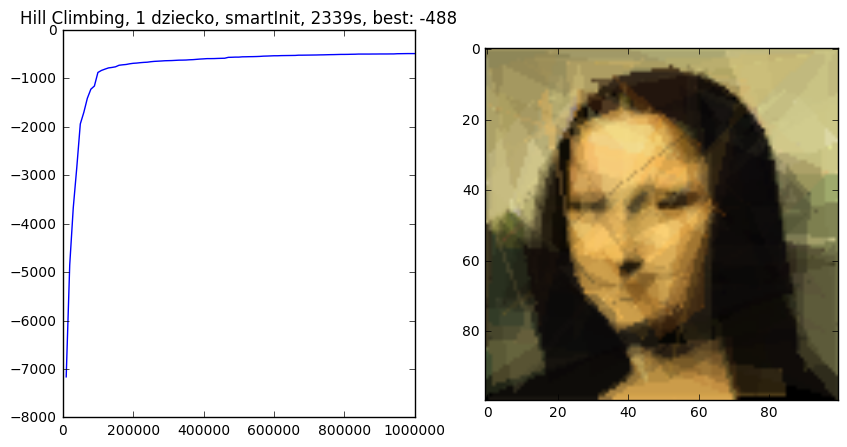

In [73]:
show(np.load('../res/hc/mona_smartInit_hc_triangular_1_1_50_10_1000000_12345.pkl'), 'Hill Climbing, 1 dziecko, smartInit,')

### Dyn. HC

Wynik w tym uruchomieniu jest liczbowo podobny do zwykłego HC, ale zauważmy, że poprzednia metoda dała obrazek mocno poszarpany. Kształty wielokątów były bardzo nieregularne i było widać dużo cięć spowodowanych granicą między kolorami. Wersja dynamiczna daje bardziej gładki obraz, co daje nadzieję na poprawę jakości przez doszlifowanie szczegółów w większej liczbie iteracji. Wydaje mi się, że pocięć na poprzednim obrazku się przez to nie usunie.

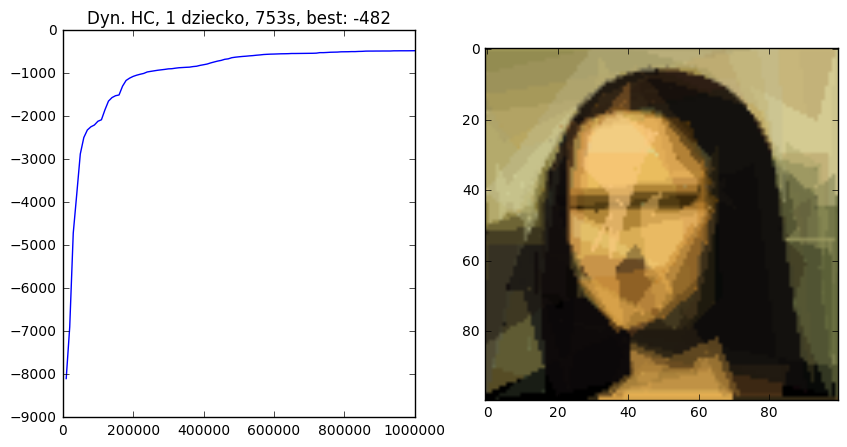

In [10]:
show(np.load('../res/hcdyn/mona_hcdyn_triangular_1_1_50_10_1000000_12345.pkl'), 'Dyn. HC, 1 dziecko,')

***

Po dwóch milionach iteracji:

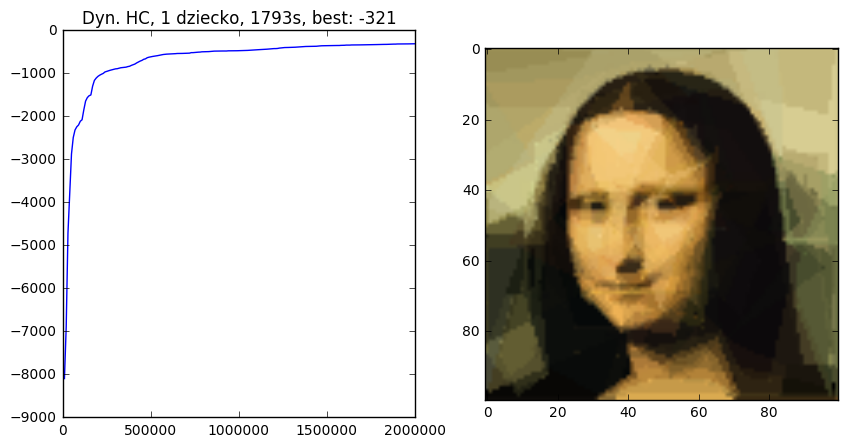

In [13]:
show(np.load('../res/hcdyn/mona_hcdyn_triangular_1_1_50_10_2000000_12345.pkl'), 'Dyn. HC, 1 dziecko,')

### Alsing HC

W stosunku do Dyn. HC dostajemy szybszą zbieżność, ale gorszy wynik po milionie iteracji. Ostateczny obrazek wygląda znacznie gorzej.

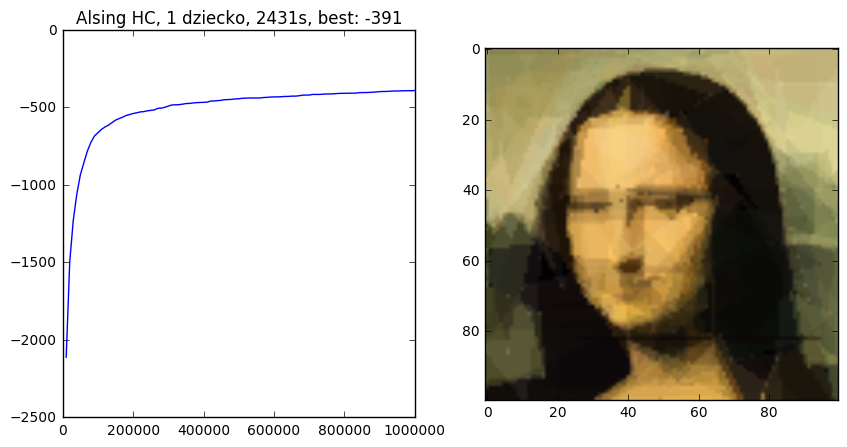

In [14]:
show(np.load('../res/hcals/mona_hcAls_1_1_50_10_1000000_12345.pkl'), 'Alsing HC, 1 dziecko,')

***

Po kolejnym milionie:

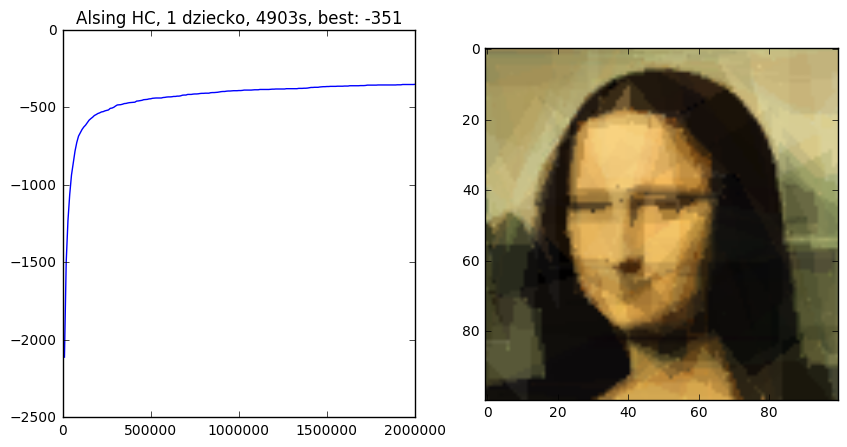

In [9]:
show(np.load('../res/hcals/mona_hcAls_1_1_50_10_2000000_12345.pkl'), 'Alsing HC, 1 dziecko,')

## Podsumowanie

W testach po milionie iteracji najlepiej poradził sobie algorytm Alsinga, chociaż po kolejnym milionie został w tyle za Dyn. HC. Patrząc na wyniki podstawowego HC widzimy, że spore znaczenie ma delikatne manipulowanie strukturą osobnika, czyli liczbą wielokątów i wierzchołków oraz kolejnością rysowania. Wersja Alsinga nie dała lepszego wyniku, chociaż jej początkowa zbieżność okazała się szybsza. Ma ona o wiele więcej parametrów i "magiczne liczby", które nie bardzo wiadomo skąd się wzięły. Możliwe, że dla optymalnych wartości rezultat byłby lepszy, ale trudno te wartości znaleźć, a sam fakt, że trzeba to robić, jest pewnym argumentem przeciwko metodzie. Do tego dochodzi spory narzut obliczeniowy na losowanie w każdej iteracji.

Dynamiczny HC znacznie upraszcza algorytm Alsinga zostawiając to, co najistotniejsze. Zmniejsza się koszt jednej iteracji, łatwiej dobrać parametry uruchomienia, a mimo to wyniki są bardzo podobne (jeśli nie lepsze).

Wygląda na to, że natura samego problemu pozwala bezpiecznie wykorzystać algorytm Hill Climbing. Bardziej liczy się tutaj liczba wykonanych kroków niż ich dokładny kierunek i kolejność.

### Możliwe ulepszenia

Podczas eksperymentów nasunął mi się pomysł zmodyfikowania prawdopodobieństw mutacji w algorytmie Alsinga. Chciałoby się, żeby wielokąty świeżo dodane miały większą szansę na duże zmiany, niż te, które są już stare. Oprócz tego szansa na dużą mutację powinna maleć w kolejnych iteracjach, a szansa na małą mutację - rosnąć. Nie miałem czasu tego zrobić, chociaż być może prosta liniowa modyfikacja prawdopodobieństw (z pewnymi dolnymi i górnymi ograniczeniami na ich wartości) już by coś pomogła.

Innym pomysłem jest dokładniejsze przyjrzenie się funkcji celu. Być może fajnie byłoby ważyć odległości poszczególnych pikseli, a nie po prostu je sumować. Można na przykład przed uruchomieniem algorytmu ewolucyjnego zrobić wykrywanie krawędzi czy obszarów o dużej różnorodności kolorów i ważyć je mocniej niż coś, co przypomina tło.

Próbowałem zamiast odległości euklidesowej liczyć odległość w przestrzeni L\*a\*b:
http://www.colorwiki.com/wiki/Delta_E:_The_Color_Difference W tym celu konwertowałem najpierw narysowanego w RGB osobnika do L\*a\*b, a następnie liczyłem różnicę za pomocą miary `Delta-E 2000`, która ma lepiej przybliżać różnicę między kolorami widoczną ludzkim okiem. Czas potrzebny na zmianę przestrzeni kolorów i obliczenie nowej odległości był jednak bardzo duży, więc w tym samym czasie wykonywaliśmy znacznie (np. o rząd wielkości) mniejszą liczbę iteracji, a wyniki wyglądały podobnie. Z tego powodu nie testowałem tej metody zbyt gruntownie, więc nawet nie zamieszczam jej w wynikach.

***

A to wyjątkowo szczęśliwe uruchomienie Dyn. HC dla którego nie zapisałem seeda :(

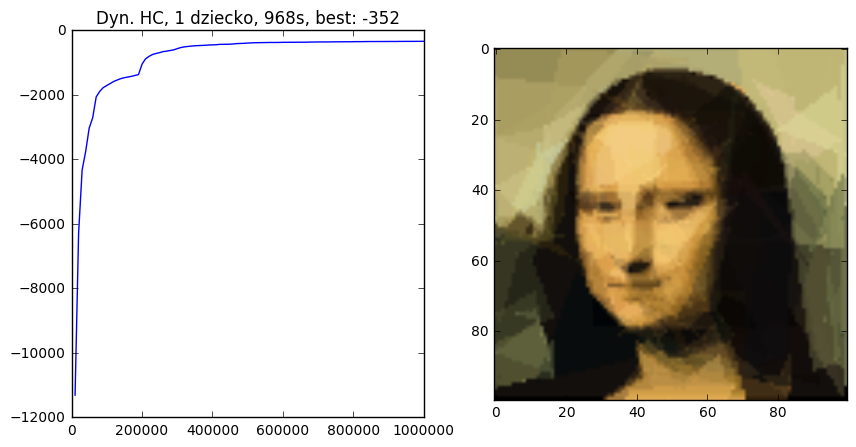

In [12]:
show(np.load('../res/hcdyn/mona_hcdyn_triangular_1_1_50_10_1000000.pkl'), 'Dyn. HC, 1 dziecko,')

***

Wyniki cząstkowe dla Dyn. HC (co 10000 iteracji):

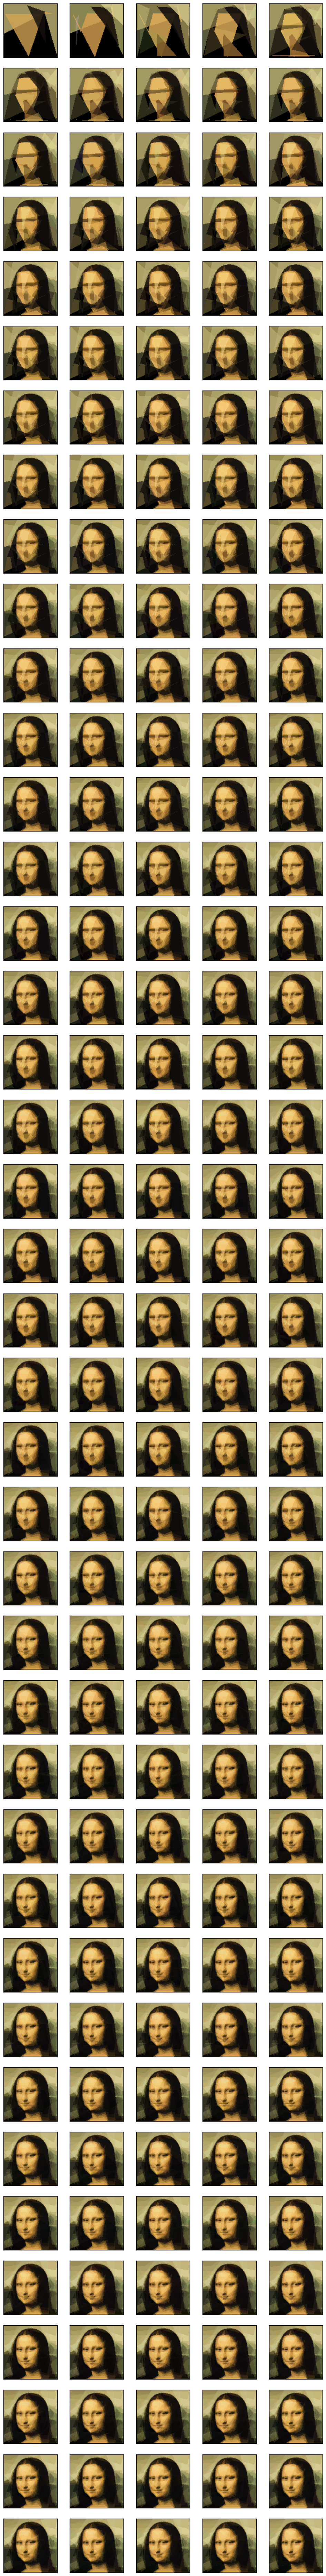

In [44]:
log = np.load('../res/hcdyn/mona_hcdyn_triangular_1_1_50_10_2000000_12345.pkl')
plt.figure(figsize=(12,96))
for i in xrange(200):
    fig = plt.subplot(40,5,i+1)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    imshow(log[i][2])
